# Sta 663


In [106]:
import os
import sys
import glob
import operator as op
import itertools as it
import scipy.stats as stats
import random
from functools import reduce, partial
import numpy as np
import numpy.linalg as la
import pandas as pd
from pandas import DataFrame, Series
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("notebook", font_scale=1.5)
%matplotlib inline

In [146]:
random.seed(147)

** Leapfrog **

This code is based on the fact that kinetic energy is $K(p) = \sum_{i=1}^n p_i^2$, i,e. all $m_i$=1

In [147]:
def leapfrog(U, grad_U, current_q, Sigma, stepsize=0.25, steps=25):
    q = current_q
    p = np.random.normal(0,1,q.size) # independent statndard normal variates
    current_p = p
    q_list=q
    p_list=p
    
    # Half step for momentum at the beginning
    p = p - stepsize*grad_U(q,Sigma)/2
    
    # Alternate full steps for position and momentum
    for i in range(steps):
        
        # Make a full step for the position
        q = q + stepsize*p
        q_list = np.vstack((q_list,q))
        
        # Make a full step for the momentum, except at end of trajectory
        if (i!=steps-1):
            p = p - stepsize*grad_U(q,Sigma)
            p_list = np.vstack((p_list,p))
    
    # Make a half step for momentum at the end
    p = p - stepsize*grad_U(q,Sigma)/2
    p_list = np.vstack((p_list,p))
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q,Sigma)
    current_K = sum(current_p**2)/2
    proposed_U = U(q,Sigma)
    proposed_K = sum(p**2)/2

    # Accept or reject the state at end of trajectory, returning either the postion at the end
    # of the trajectory or the initial position
    if (np.random.uniform(0,1) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return(q,p_list,q_list) # Accept
    else:
        return(current_q,p_list,q_list) # Reject
    

**2D gaussian example**

In [148]:
def U(q,Sigma):
    '''
    Returns -log p(q)
    '''
    from scipy.stats import multivariate_normal
    return (-np.log(multivariate_normal.pdf(q, mean=[0,0], cov = Sigma)))

def grad_U(q,Sigma):
    return(np.dot(q,la.inv(Sigma)))

**Running the function**

In [149]:
current_q = np.array([-1.5,-1.55])
Sigma2 = np.array([[1, 0.95],[0.95,1]])
q,p_list,q_list=leapfrog(U, grad_U, current_q, Sigma = Sigma2, stepsize=0.25, steps=25)

**Corresponding HMC values**

In [150]:
Hamiltonian_value = np.zeros(26)
for i in range(26):
    Hamiltonian_value[i] = U(q_list[i,:],Sigma2)+ np.dot(p_list[i,:].T,p_list[i,:])/2

**Illustration of HMC paths**

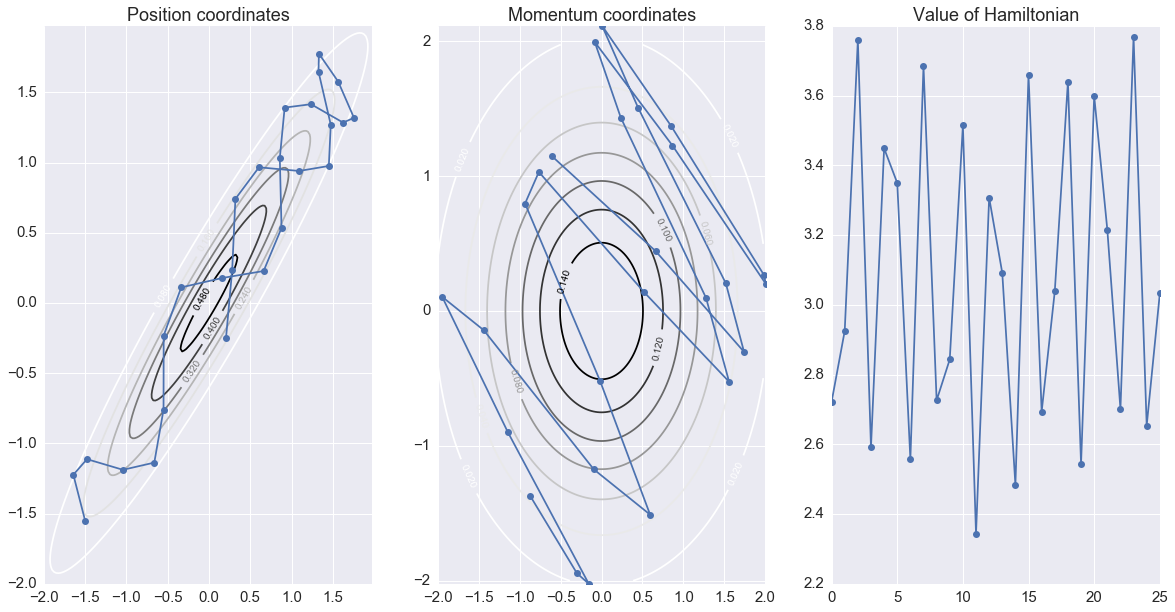

In [151]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab

delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(20,10))
plt.subplot(131)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates')
plt.plot(q_list[:,0], q_list[:,1], '-o')

plt.subplot(132)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Momentum coordinates')
plt.plot(p_list[:,0], p_list[:,1], '-o')

plt.subplot(133)
plt.plot(np.arange(Hamiltonian_value.size), Hamiltonian_value, '-o')
plt.title('Value of Hamiltonian')
pass

**Critical stepsize**


At a critical stepsize the trajectory becomes unstable and the value of Hamiltonian grows without bound.

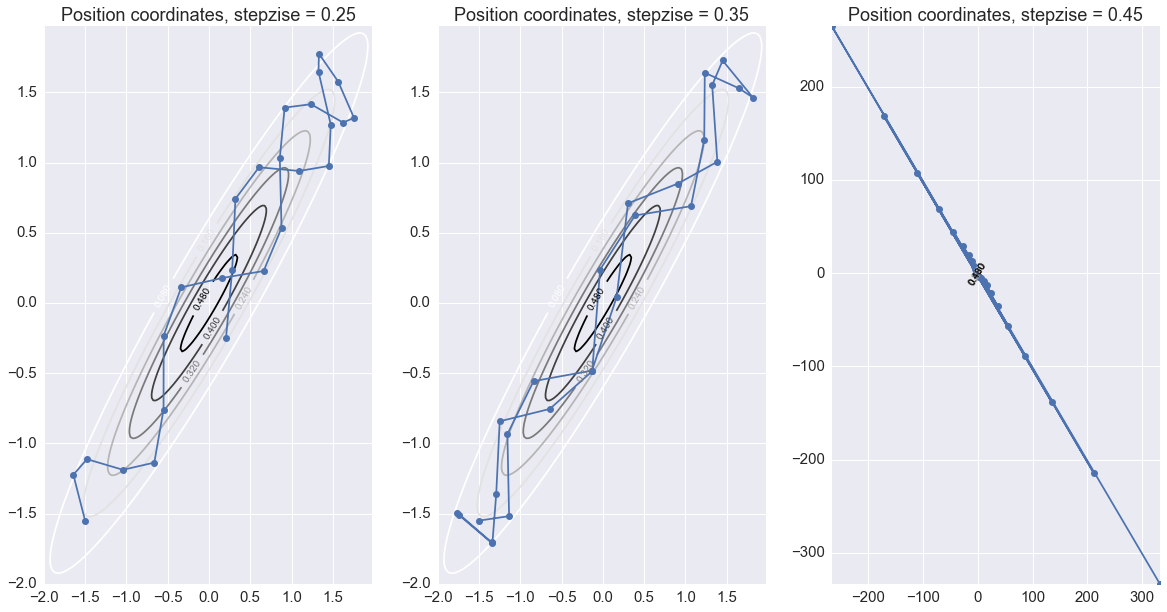

In [152]:
current_q = np.array([-1.5,-1.55])
q1,p1_list,q1_list=leapfrog(U, grad_U, current_q, Sigma2, stepsize=0.35, steps=25)
current_q = np.array([-1.5,-1.55])
q2,p2_list,q2_list=leapfrog(U, grad_U, current_q, Sigma2, stepsize=0.45, steps=25)

#Plotting 
plt.figure(figsize=(20,10))
plt.subplot(131)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.25')
plt.plot(q_list[:,0], q_list[:,1], '-o')

plt.subplot(132)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.35')
plt.plot(q1_list[:,0], q1_list[:,1], '-o')

plt.subplot(133)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.45')
plt.plot(q2_list[:,0], q2_list[:,1], '-o')
pass

# HMC vs MH sampling

$20$ iterations of the HMC(with $20$ Leapfrog steps per trajectory) for a 2D Gaussian distribution with marginal standard deviations of $1$ and correlation $0.98$.

**HMC**

In [153]:
def HMC(U, grad_U, current_q, Sigma, stepsize=0.2, steps=25, max_iter= 20):
    current_q_list = current_q
    current_q,p_list,q_list = leapfrog(U, grad_U, current_q, Sigma, stepsize, steps)
    current_q_list = np.vstack((current_q_list,current_q))
    for i in range(max_iter):
        current_q,p_list,q_list = leapfrog(U, grad_U, current_q, Sigma, stepsize, steps)
        current_q_list = np.vstack((current_q_list,current_q))
    return(current_q_list[:-2,:])

**Running the HMC**

In [154]:
Sigma2_high_cor = np.array([[1, 0.98],[0.98,1]])
current_q = np.array([-1.5,-1.55])
current_q_list=HMC(U, grad_U, current_q, Sigma2_high_cor, stepsize=0.18, steps=20, max_iter=200)

**MH**

In [155]:
import numpy as np
def metropolis_multigaus(target,proposal,thin,niters,dim):
    post = np.zeros((niters,dim))
    current = proposal.rvs()
    accept = 0
    for i in range(thin*niters):
        post_p = current + proposal.rvs()
        rho = min(1, target.pdf(post_p)/target.pdf(current))
        u = np.random.uniform()
        if u < rho:
            accept += 1
            current = post_p
        if i % thin < 1:
            post[i//thin,:] = current
    return(post,accept/(niters*thin))

**Running the MH**

In [156]:
mu = np.array([0,0])
cov_mat = (np.array([[1,.98],[.98,1]]))

mu_prop = np.array([0,0])
cov_prop = (np.array([[.18**2,0],[0,.18**2]]))
target2d = stats.multivariate_normal(mu,cov_mat)
proposal2d = stats.multivariate_normal(mu_prop,cov_prop)

res, ratio = metropolis_multigaus(target2d,proposal2d,20,200,2)

**MH vs HMC plots**

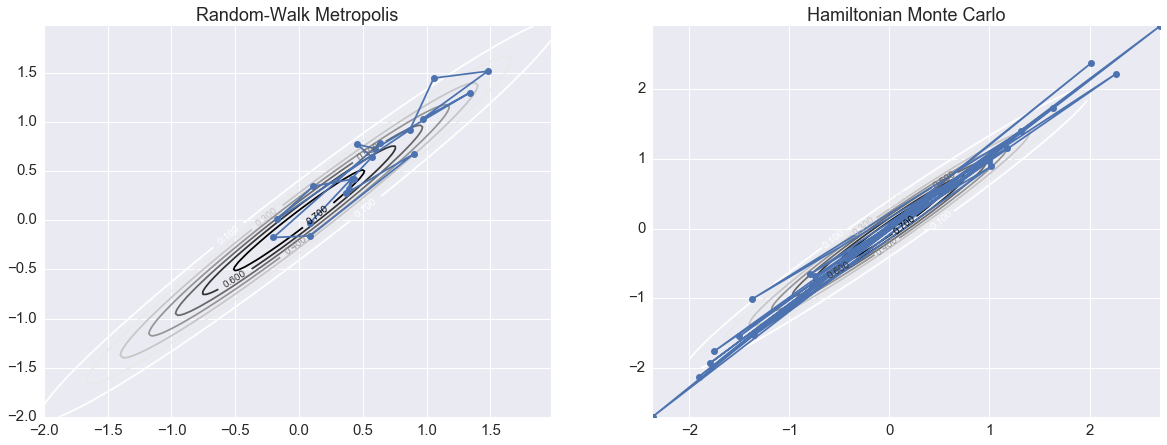

In [157]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab

delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(20,7))

plt.subplot(121)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Random-Walk Metropolis')
plt.plot(res[0:19,0],res[0:19,1], '-o')

plt.subplot(122)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Hamiltonian Monte Carlo')
plt.plot(current_q_list[0:20:,0], current_q_list[0:20:,1], '-o')

pass

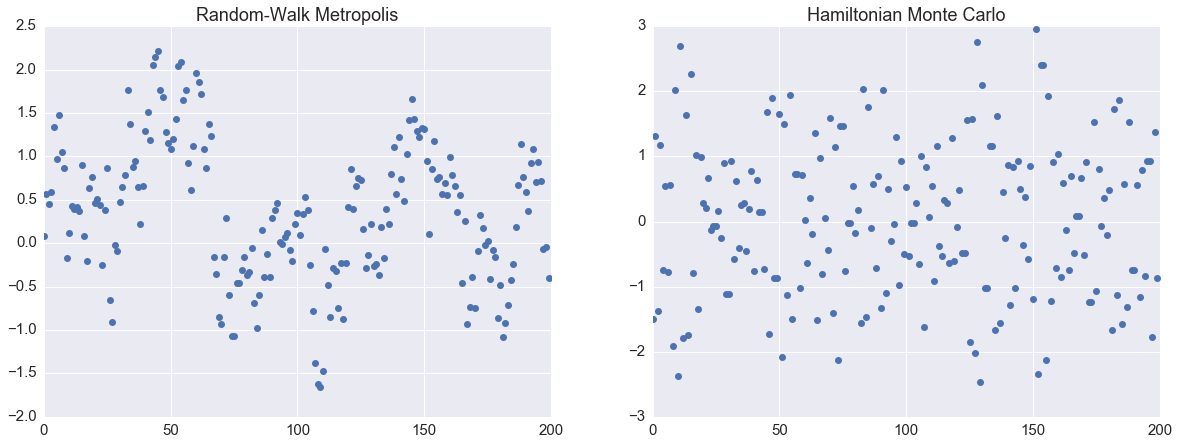

In [158]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.plot(range(len(res[:,0])),res[:,0], 'o')
plt.title('Random-Walk Metropolis')

plt.subplot(122)
plt.title('Hamiltonian Monte Carlo')
plt.plot(range(len(current_q_list[:,0])), current_q_list[:,0], 'o')

pass